# L-DED Audiovisual Fusion 

Author: Chen Lequn.
Created on 01 Feb 2023.

- Material： Maraging Steel 300
- Process: Robotic Llser-directed energy deposition
- Experiment number (single bead wall samples): 21-26
- Recorded data: position, veolocity, coaxial melt pool images, acoustic data
- Defect generated: keyhole pores, cracks, defect-free

### Notebook 3: benchmarking on audio dataset

- Performances for various deep learning models (VGG, GoogleNet, ResNet, LeNet, etc.) are evaluated and benchmarked on the coaxial melt pool image dataset.
- Best performance will guide subsequent multimodal fusion network development.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.multiprocessing as mp

import torchvision
import torchaudio
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

# audio signal augmentation packages
import audiomentations
import torch_audiomentations
from audiomentations import Compose, AddGaussianNoise, HighPassFilter, BandPassFilter, LoudnessNormalization
from audiomentations import Normalize, Gain

from torch_audiomentations import PolarityInversion

import os
import argparse
from torch.utils.data import Subset
import pandas as pd
import numpy as np

# Scikit learn
#from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle, resample, class_weight
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import label_binarize

from audio_models import * 
from multimodaldataset import MultimodalDataset, LDEDAudioDataset, LDEDVisionDataset
from utils import *
from train_utils import train_single_epoch, test_single_epoch, training_loop

## plot
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib.pyplot import gca
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times New Roman"
%matplotlib inline
import seaborn as sns
from itertools import cycle
import itertools


# Multimodal_dataset_PATH = os.path.join("C:\\Users\\Asus\\OneDrive_Chen1470\\OneDrive - Nanyang Technological University\\Dataset\\Multimodal_AM_monitoring\\LDED_Acoustic_Visual_Dataset")
# Multimodal_dataset_PATH = os.path.join("/home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset")
# Image_path = os.path.join(Multimodal_dataset_PATH,'Video', 'segmented',  'images')
# Audio_raw_seg_PATH = os.path.join(Multimodal_dataset_PATH, 'Video', 'segmented', 'raw_audio')
# Audio_equalized_seg_PATH = os.path.join(Multimodal_dataset_PATH, 'Video', 'segmented', 'equalized_audio')
# Audio_bandpassed_seg_PATH = os.path.join(Multimodal_dataset_PATH, 'Video', 'segmented', 'bandpassed_audio')
# Audio_denoised_seg_PATH = os.path.join(Multimodal_dataset_PATH,'Video', 'segmented',  'denoised_audio')

# AUDIO_DIR = Audio_denoised_seg_PATH
# VISON_DIR = Image_path

# torch.manual_seed(0)

# ANNOTATIONS_FILE = os.path.join(Multimodal_dataset_PATH, 'Video', 'segmented', "visual_acoustic_dataset_annotations_v2.csv")

In [2]:
def get_sample_directories(base_path, sample_numbers):
    sample_directories = []
    for sample_number in sample_numbers:
        sample_directories.append(os.path.join(base_path, f'segmented_25Hz/{sample_number}'))
    return sample_directories

Multimodal_dataset_PATH = "/home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset"
samples = [21, 22, 23, 26]
sample_directories = get_sample_directories(Multimodal_dataset_PATH, samples)

# Get lists of image and audio directories for each sample
image_directories = [os.path.join(sample_dir, 'images') for sample_dir in sample_directories]
audio_directories = [os.path.join(sample_dir, 'raw_audio') for sample_dir in sample_directories]

In [3]:
classes = ('Laser-off', 'Defect-free', 'Defective')
# classes = ('Laser-off', 'Defect-free', 'Cracks', "Keyhole pores")
SAMPLE_RATE = 44100
LEARNING_RATE = 0.00001
BATCH_SIZE = 32
EPOCHS = 15

### Utils functions

In [4]:
PROJECT_ROOT_DIR = "../"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'train_audio')
os.makedirs(IMAGE_PATH, exist_ok=True)

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

### Use GPU if possible

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")
mp.set_start_method(method='forkserver', force=True)

Using cuda


### Annotation file

- Vision acoustic spatio-temporal registration has been done in our previous work. 
- Each frame (timestamp) corresponds to a robot TCP position.
- The duration for each frame is 0.01 seconds (sampling freqeuncy 10 Hz.)

In [6]:
# Combine all annotation files into one DataFrame
all_annotation_dfs = []
for sample_dir, sample_number in zip(sample_directories, samples):
    annotation_file = os.path.join(sample_dir, f'annotations_{sample_number}.csv')  # Update the file name
    annotation_df = pd.read_csv(annotation_file)
    all_annotation_dfs.append(annotation_df)
combined_annotation_df = pd.concat(all_annotation_dfs)

combined_annotation_df = combined_annotation_df.dropna(subset=['name'])
combined_annotation_df

,sample index,audio_file_name,image_file_name,name,class_ID,class_name_v2,class_ID_2,Layer number,Sample number,X,Y,Z,class_ID_v2
0,1,sample_21_1.wav,sample_21_1.jpg,Laser-off,0.0,Laser-off,0.0,1.0,21,0.136620,0.265042,9.588183,NaN
1,2,sample_21_2.wav,sample_21_2.jpg,Crack,2.0,Defective,2.0,1.0,21,0.128219,0.275541,3.966295,NaN
2,3,sample_21_3.wav,sample_21_3.jpg,Crack,2.0,Defective,2.0,1.0,21,0.126358,0.276802,2.995122,NaN
3,4,sample_21_4.wav,sample_21_4.jpg,Crack,2.0,Defective,2.0,1.0,21,0.124890,0.278469,2.108443,NaN
4,5,sample_21_5.wav,sample_21_5.jpg,Defect-free,1.0,Defect-free,1.0,1.0,21,0.124157,0.278818,1.804407,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10981,10982,sample_26_10982.wav,sample_26_10982.jpg,Laser-off,0.0,Laser-off,0.0,50.0,26,0.049586,0.332865,19.726104,NaN
10982,10983,sample_26_10983.wav,sample_26_10983.jpg,Laser-off,0.0,Laser-off,0.0,50.0,26,0.049608,0.332879,19.705723,NaN
10983,10984,sample_26_10984.wav,sample_26_10984.jpg,Laser-off,0.0,Laser-off,0.0,50.0,26,0.049623,0.332923,19.733791,NaN
10984,10985,sample_26_10985.wav,sample_26_10985.jpg,Laser-off,0.0,Laser-off,0.0,50.0,26,0.049646,0.332933,19.690738,NaN


In [7]:
# Get the labels and count the number of samples for each class
labels = combined_annotation_df['name'].values
label_counts = np.unique(labels, return_counts=True)[1]
print (label_counts)

[ 1431  9056  4841 12520]


### Basline accuracy
The baseline accuracy in this multi-class classificiation problem is **43%**, which is the accuracy of trivially predicting the most-frequent class (classify to the largest class– in other words).

In [8]:
### Get the percentage distribution of each category
round(combined_annotation_df.groupby('class_name_v2')["class_name_v2"].count()/combined_annotation_df.shape[0]*100, 1)

class_name_v2
Defect-free    32.5
Defective      22.5
Laser-off      45.0
Name: class_name_v2, dtype: float64

Saving figure dataset


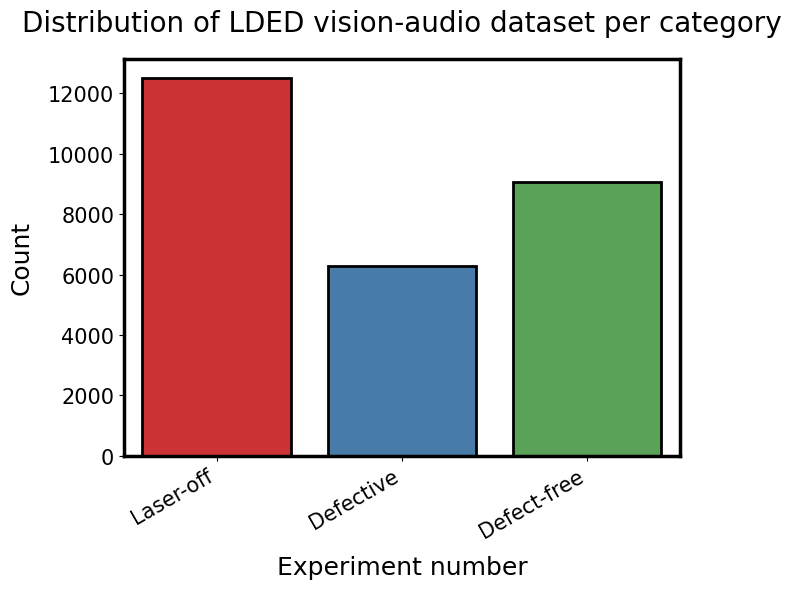

In [9]:
# sns.set(style="darkgrid")
plt.figure(figsize = (7,6))


ax = sns.countplot(x='class_name_v2', data = combined_annotation_df, palette="Set1", linewidth=2,
                   edgecolor='k'); #palette='mako' 'Set2'
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
# ax = sns.countplot(y='label', data = df_dataset_denoised, palette="Set2");


ax.set_title('Distribution of LDED vision-audio dataset per category', fontsize = 20, pad=20);
ax.set_xlabel("Experiment number",fontsize=18, labelpad=10)
ax.set_ylabel("Count",fontsize=18, labelpad=10)
ax.tick_params(labelsize=15)

save_fig("dataset")

## Preparing Dataset and DataLoader

In [10]:
#------ transformation------
# instantiating our dataset object and create data loader
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=512,
    hop_length=256,
    n_mels=32
)

MFCCs = torchaudio.transforms.MFCC(sample_rate=SAMPLE_RATE,n_mfcc=20)



augmentation = Compose(
    [
       AddGaussianNoise(min_amplitude=0.01, max_amplitude=0.015, p=0.5),
       # HighPassFilter(min_cutoff_freq=1000, max_cutoff_freq=21000, p=0.5),
       BandPassFilter(min_center_freq=1000, max_center_freq=21000, p=0.5),
       # Gain(min_gain_in_db = -2, max_gain_in_db = 2, p=0.5),
       Normalize(p=0.5)
    ]
)


# Initialize augmentation callable
apply_augmentation = Compose(
    transforms=[
        Gain(
            min_gain_in_db=-15.0,
            max_gain_in_db=5.0,
            p=0.5,
        ),
        PolarityInversion(p=0.5)
    ]
)

train_transform = transforms.Compose([
    # augmentation,
    # apply_augmentation,
    # torchaudio.transforms.TimeMasking(time_mask_param=20, p=0.5),  # apply time masking with probability of 0.5
    # torchaudio.transforms.FrequencyMasking(freq_mask_param=20),  # apply time masking with probability of 0.5
    torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=512, hop_length=256, n_mels=32),  # compute Mel-frequency cepstral coefficients (MFCCs)
])


In [11]:
#------ data loader------
# create the dataset for all samples
audiodataset = LDEDAudioDataset(combined_annotation_df,
                                audio_directories,
                                samples,
                                mel_spectrogram,
                                # MFCCs,
                                # spectral_centroid,
                                SAMPLE_RATE,
                                device)
print ("length of the total dataset:" + str(len(audiodataset)))

length of the total dataset:27848


### Dealing with Imbalanced dataset: stratified sampling

- Split the data into train, validation, and test set
- Train and Val are used for hyperparameter tuning
- Train set will go through some data augmentation

In [12]:
# Split the data into train and validation datasets
# train_annotations, val_annotations = train_test_split(annotations_df, test_size=0.2)
# create the StratifiedShuffleSplit object
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

# split the indices of annotations into train and test sets
train_indices, test_indices = next(sss.split(combined_annotation_df, labels))

# split the data into train and test sets
train_annotations = combined_annotation_df.iloc[train_indices, :]
test_annotations = combined_annotation_df.iloc[test_indices, :]

# Create the train and validation datasets
train_dataset = LDEDAudioDataset(train_annotations,
                                 audio_directories,
                                 samples, 
                                 mel_spectrogram,
                                 SAMPLE_RATE,
                                 device=device)

val_dataset = LDEDAudioDataset(test_annotations,
                               audio_directories,
                               samples,
                               mel_spectrogram,
                               SAMPLE_RATE,
                               device=device)

### Create DataLoader using the dataset

In [13]:
# # Create train and val dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
# test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("length of the train dataset:" +  str(len(train_dataloader.dataset)))
print("length of the val dataset:" +  str(len(val_dataloader.dataset)))
# print("length of the test dataset:" +  str(len(test_dataloader.dataset)))

length of the train dataset:22278
length of the val dataset:5570


## Training the model

In [14]:
resume = False
start_epoch = 0
best_acc = 0

In [15]:
# -----Model---------------
print('==> Building model..')

net = MFCCCNN() 

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
    print ("--- Using CUDA ---")

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

loss_fn = nn.CrossEntropyLoss()
# Note: weight_decay in pytorch is L2 regularization
# optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE,
#                     momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


# for epoch in range(start_epoch, start_epoch+EPOCHS):
    # train_single_epoch(net, epoch, train_dataloader, loss_fn, optimizer, device)
    # test_single_epoch(net, epoch, val_dataloader, loss_fn, device)
    # scheduler.step()

model, optimizer, (train_losses, valid_losses, train_accuracy, valid_accuracy) = training_loop(net, loss_fn, optimizer, train_dataloader, val_dataloader, EPOCHS, scheduler, device)

==> Building model..
--- Using CUDA ---

Epoch: 0


Epoch 0:   0%|               | 0/175 [00:10<?, ?it/s, loss=0.864, accuracy=70.2]


16:31:24 --- Epoch: 0	Train loss: 0.9806	Valid loss: 0.0272	Train accuracy: 63.82	Valid accuracy: 70.23

Epoch: 1


Epoch 1:   0%|               | 0/175 [00:13<?, ?it/s, loss=0.811, accuracy=74.4]


16:31:56 --- Epoch: 1	Train loss: 0.8479	Valid loss: 0.0255	Train accuracy: 71.02	Valid accuracy: 74.42

Epoch: 2


Epoch 2:   0%|               | 0/175 [00:11<?, ?it/s, loss=0.787, accuracy=76.6]


16:32:28 --- Epoch: 2	Train loss: 0.8141	Valid loss: 0.0247	Train accuracy: 74.06	Valid accuracy: 76.62

Epoch: 3


Epoch 3:   0%|               | 0/175 [00:11<?, ?it/s, loss=0.769, accuracy=78.2]


16:32:59 --- Epoch: 3	Train loss: 0.7940	Valid loss: 0.0242	Train accuracy: 75.95	Valid accuracy: 78.22

Epoch: 4


Epoch 4:   0%|               | 0/175 [00:12<?, ?it/s, loss=0.757, accuracy=79.7]


16:33:33 --- Epoch: 4	Train loss: 0.7783	Valid loss: 0.0238	Train accuracy: 77.48	Valid accuracy: 79.68

Epoch: 5


Epoch 5:   0%|               | 0/175 [00:10<?, ?it/s, loss=0.747, accuracy=80.6]


16:34:03 --- Epoch: 5	Train loss: 0.7656	Valid loss: 0.0235	Train accuracy: 78.81	Valid accuracy: 80.59

Epoch: 6


Epoch 6:   0%|               | 0/175 [00:14<?, ?it/s, loss=0.739, accuracy=81.6]


16:34:40 --- Epoch: 6	Train loss: 0.7568	Valid loss: 0.0232	Train accuracy: 79.72	Valid accuracy: 81.60

Epoch: 7


Epoch 7:   0%|               | 0/175 [00:12<?, ?it/s, loss=0.732, accuracy=82.1]


16:35:12 --- Epoch: 7	Train loss: 0.7481	Valid loss: 0.0230	Train accuracy: 80.66	Valid accuracy: 82.06

Epoch: 8


Epoch 8:   0%|               | 0/175 [00:13<?, ?it/s, loss=0.726, accuracy=82.7]


16:35:45 --- Epoch: 8	Train loss: 0.7409	Valid loss: 0.0228	Train accuracy: 81.32	Valid accuracy: 82.73

Epoch: 9


Epoch 9:   0%|                 | 0/175 [00:12<?, ?it/s, loss=0.721, accuracy=83]


16:36:17 --- Epoch: 9	Train loss: 0.7345	Valid loss: 0.0226	Train accuracy: 81.94	Valid accuracy: 83.02

Epoch: 10


Epoch 10:   0%|              | 0/175 [00:13<?, ?it/s, loss=0.717, accuracy=83.5]


16:36:48 --- Epoch: 10	Train loss: 0.7313	Valid loss: 0.0225	Train accuracy: 82.29	Valid accuracy: 83.46

Epoch: 11


Epoch 11:   0%|              | 0/175 [00:11<?, ?it/s, loss=0.714, accuracy=83.9]


16:37:21 --- Epoch: 11	Train loss: 0.7260	Valid loss: 0.0224	Train accuracy: 82.79	Valid accuracy: 83.88

Epoch: 12


Epoch 12:   0%|              | 0/175 [00:12<?, ?it/s, loss=0.712, accuracy=83.9]


16:37:53 --- Epoch: 12	Train loss: 0.7229	Valid loss: 0.0224	Train accuracy: 83.14	Valid accuracy: 83.90

Epoch: 13


Epoch 13:   0%|                | 0/175 [00:11<?, ?it/s, loss=0.709, accuracy=84]


16:38:27 --- Epoch: 13	Train loss: 0.7211	Valid loss: 0.0223	Train accuracy: 83.22	Valid accuracy: 84.02

Epoch: 14


Epoch 14:   0%|              | 0/175 [00:11<?, ?it/s, loss=0.709, accuracy=84.2]

16:38:57 --- Epoch: 14	Train loss: 0.7185	Valid loss: 0.0223	Train accuracy: 83.42	Valid accuracy: 84.18


In [16]:
valid_accuracy

[70.23339317773788,
 74.41651705565529,
 76.62477558348294,
 78.2226211849192,
 79.67684021543985,
 80.59245960502693,
 81.59784560143626,
 82.06463195691202,
 82.72890484739676,
 83.016157989228,
 83.46499102333932,
 83.87791741472172,
 83.89587073608618,
 84.02154398563734,
 84.18312387791741]

Saving figure train_lost_curve_audio


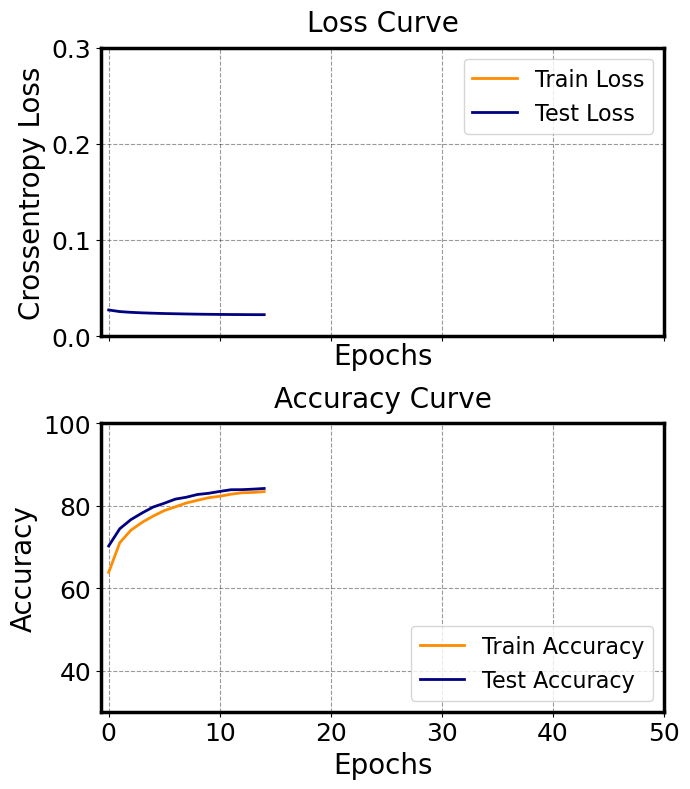

In [17]:
loss_acc_plot(train_losses, valid_losses, train_accuracy, valid_accuracy, 50, "Initial Training",
              interval=10, yloss_limit1=0, yloss_limit2=0.3, yacc_limit1=30, yacc_limit2=100)

save_fig ("train_lost_curve_audio")

In [18]:
get_accuracy(model, val_dataloader, device)

0.8418312387791741

Test Accuracy (cross-validation) for MFCC-CNN = 0.84183 ± 0.00814
micro-averaging AUC for MFCC-CNN = 0.91091 ± 0.00000
Saving figure ROC_curve (acoustic-based)


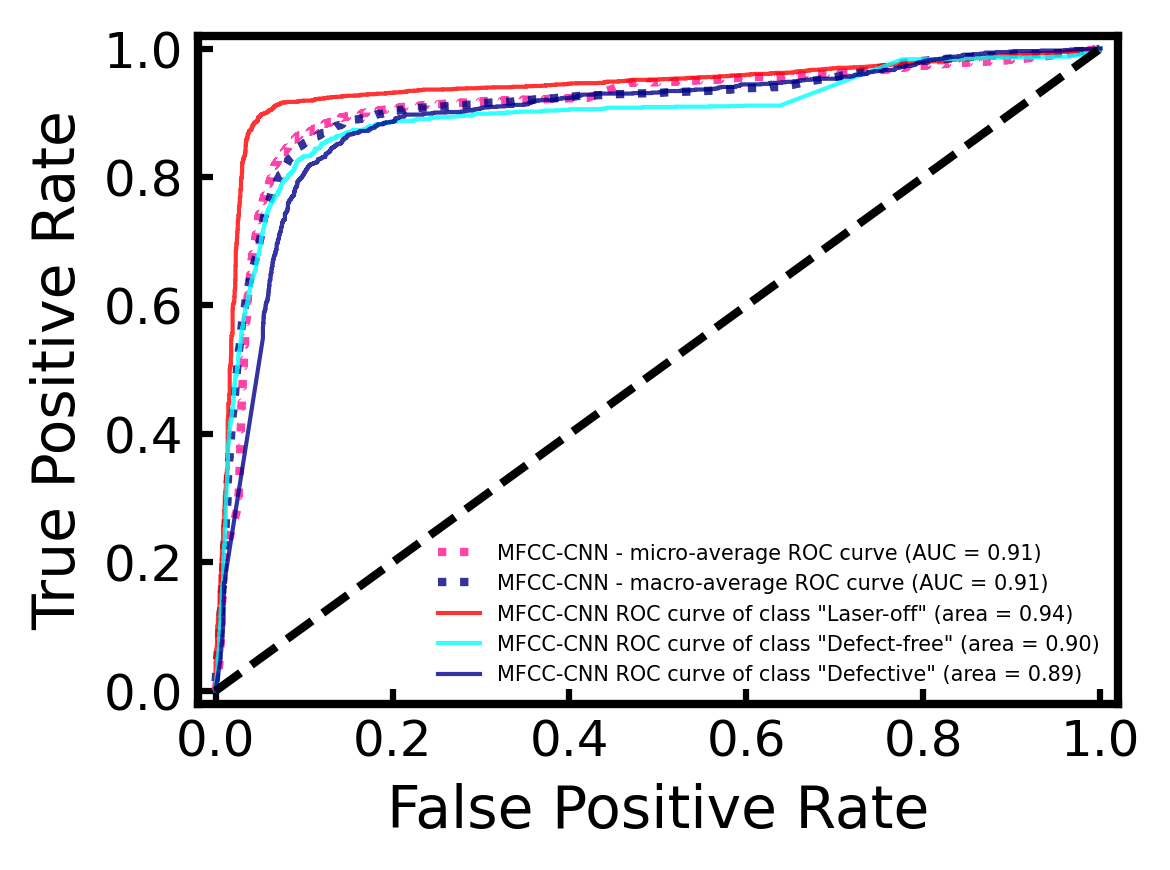

In [19]:
test_accuracy_mean, test_accuracy_std, auc_mean, auc_std = model_evaluation(model, val_dataloader, classes, device, classifier_name = "MFCC-CNN", signal_type = "denoised", seed=0)

save_fig ("ROC_curve (acoustic-based)")

In [20]:
yt, yp = class_report(model, val_dataloader, device, classes)

              precision    recall  f1-score   support

 Defect-free     0.8359    0.7870    0.8107      1812
   Defective     0.7101    0.7951    0.7502      1254
   Laser-off     0.9211    0.9050    0.9130      2504

    accuracy                         0.8418      5570
   macro avg     0.8224    0.8290    0.8246      5570
weighted avg     0.8459    0.8418    0.8430      5570



[[1426  292   94]
 [ 157  997  100]
 [ 123  115 2266]]
Saving figure confusion_matrix(audio_based)


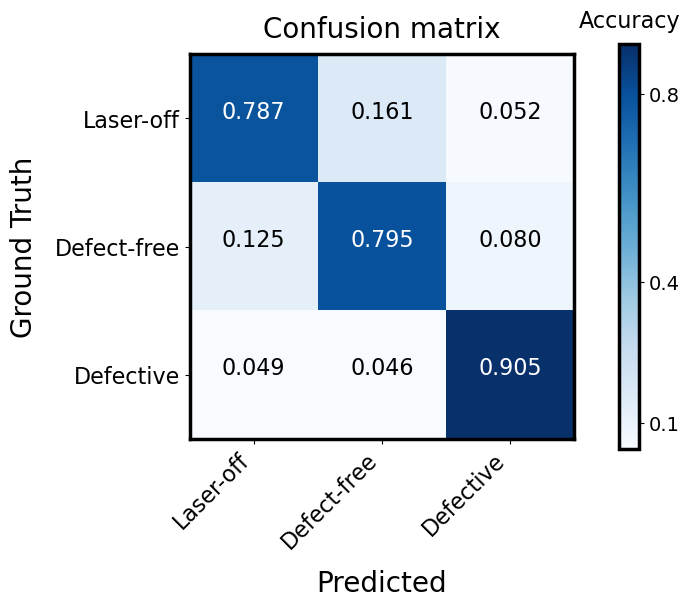

In [21]:
conf_matrix(yt, yp, classes)
save_fig("confusion_matrix(audio_based)")